In [ ]:
from selenium import webdriver

chrome_path = "C:\chromedriver.exe"
driver = webdriver.Chrome(chrome_path)

driver.get("http://www.opinet.co.kr")
driver.implicitly_wait(10)
driver.find_element_by_xpath('''//*[@id="quick_ul"]/li[2]/a''').click()
gu_list_raw = driver.find_element_by_xpath("""//*[@id="SIGUNGU_NM0"]""")
gu_list = gu_list_raw.find_elements_by_tag_name("option") #element: 명령어 1개, elements: 명령어 전부를 리스트 형으로 반환
gu_names = [option.get_attribute("value") for option in gu_list]
gu_names.remove('')
gu_names

import time
from tqdm import tqdm_notebook

for gu in tqdm_notebook(gu_names):
    element = driver.find_element_by_id("SIGUNGU_NM0")
    element.send_keys(gu)
    
    time.sleep(2)
    
    xpath = """//*[@id="searRgSelect"]"""
    element_sel_gu = driver.find_element_by_xpath(xpath).click()
    
    time.sleep(1)
    
    xpath = """//*[@id="glopopd_excel"]"""
    element_get_excel = driver.find_element_by_xpath(xpath).click()
    
    time.sleep(1)

In [ ]:
import pandas as pd
from glob import glob

stations_files = glob("C:\\Users\\Downloads\\지역_위치별*.xls")
stations_files

In [ ]:
tmp_raw = []
for file_name in stations_files:
    tmp = pd.read_excel(file_name, header=2)
    tmp_raw.append(tmp)

station_raw = pd.concat(tmp_raw)

In [ ]:
stations = pd.DataFrame({'Oil_store':station_raw['상호'],
                            '주소':station_raw['주소'],
                            '가격':station_raw['휘발유'],
                            '셀프':station_raw['셀프여부'],
                            '상표':station_raw['상표']})

stations.head()

,Oil_store,주소,가격,셀프,상표
0,재건에너지 재정제2주유소 고속셀프지점,서울특별시 강동구 천호대로 1246 (둔촌제2동),1769,Y,현대오일뱅크
1,구천면주유소,서울 강동구 구천면로 357 (암사동),1783,N,현대오일뱅크
2,지에스칼텍스㈜ 신월주유소,서울 강동구 양재대로 1323 (성내동),1808,N,GS칼텍스
3,방아다리주유소,서울 강동구 동남로 811 (명일동),1810,Y,SK에너지
4,지에스칼텍스㈜ 동서울주유소,서울 강동구 천호대로 1456 (상일동),1815,Y,GS칼텍스


In [ ]:
stations['구'] = [eachAddress.split()[1] for eachAddress in stations['주소']]
stations['구'].unique()

array(['강동구', '동대문구', '동작구', '마포구', '서대문구', '서초구', '성동구', '성북구', '송파구',
       '양천구', '영등포구', '강북구', '용산구', '은평구', '종로구', '중구', '중랑구', '강서구',
       '관악구', '광진구', '구로구', '금천구', '노원구', '도봉구', '강남구'], dtype=object)

In [ ]:
# 가격이 기입되지 않은 주유소는 제외
stations[stations['가격'] == '-'] 

# 가격이 기입된 컬럼은 float형으로 변환
stations = stations[stations['가격'] != '-']
stations['가격'] = [float(value) for value in stations['가격']]

In [ ]:
stations.reset_index(inplace=True, drop=True)
stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 464 entries, 0 to 463
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Oil_store  464 non-null    object 
 1   주소         464 non-null    object 
 2   가격         464 non-null    float64
 3   셀프         464 non-null    object 
 4   상표         464 non-null    object 
 5   구          464 non-null    object 
dtypes: float64(1), object(5)
memory usage: 21.9+ KB


Using matplotlib backend: Qt5Agg


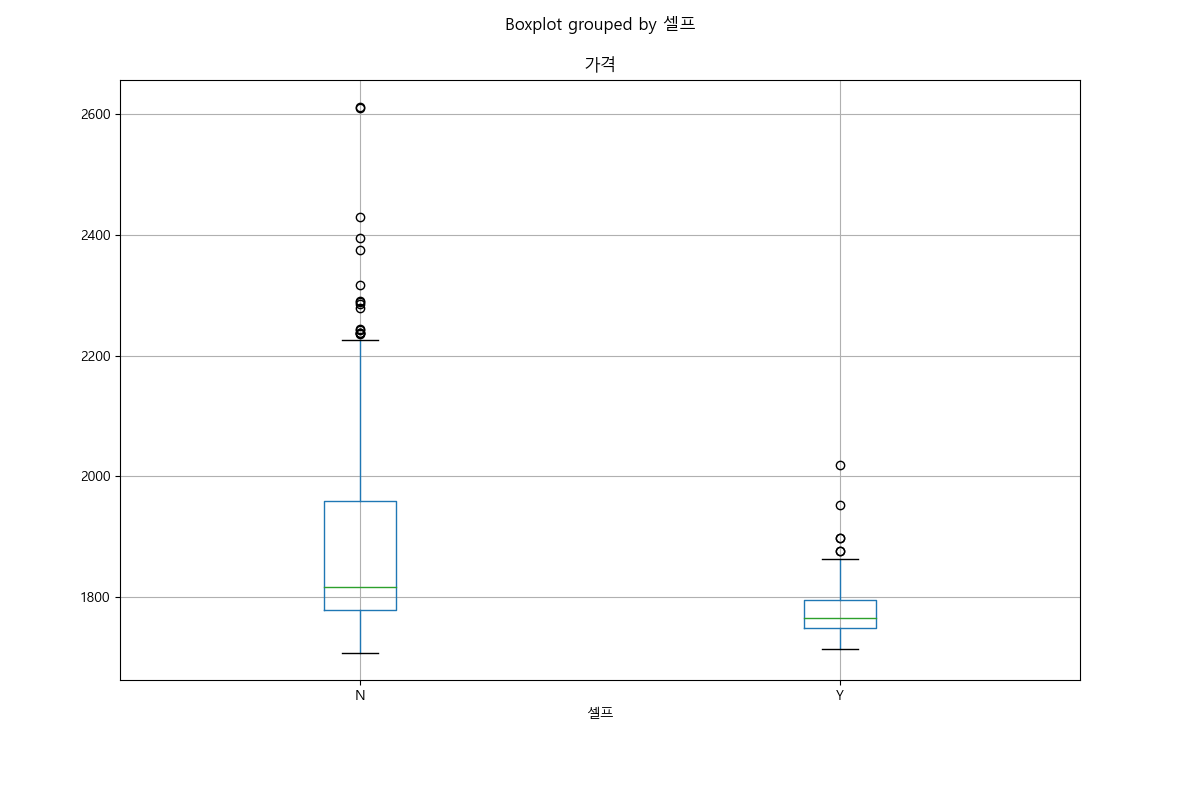

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib
from IPython.display import Image

stations.boxplot(column='가격', by='셀프', figsize=(12,8))
Image("./Figure_1.png")

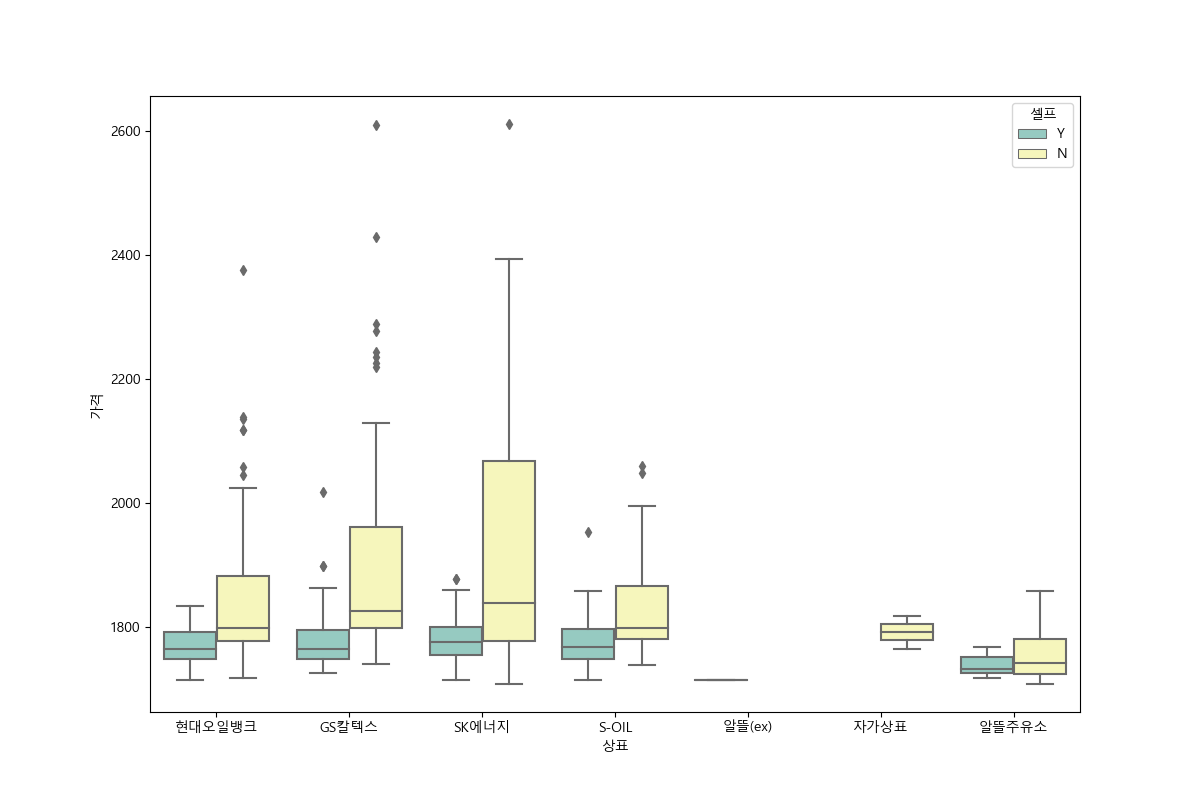

In [ ]:
# 주유소 브랜드별 셀프 주유소가 얼마나 저렴한지 확인
plt.figure(figsize=(12,8))
sns.boxplot(x='상표', y='가격', hue='셀프', data=stations, palette='Set3')
Image("./Figure_2.png")

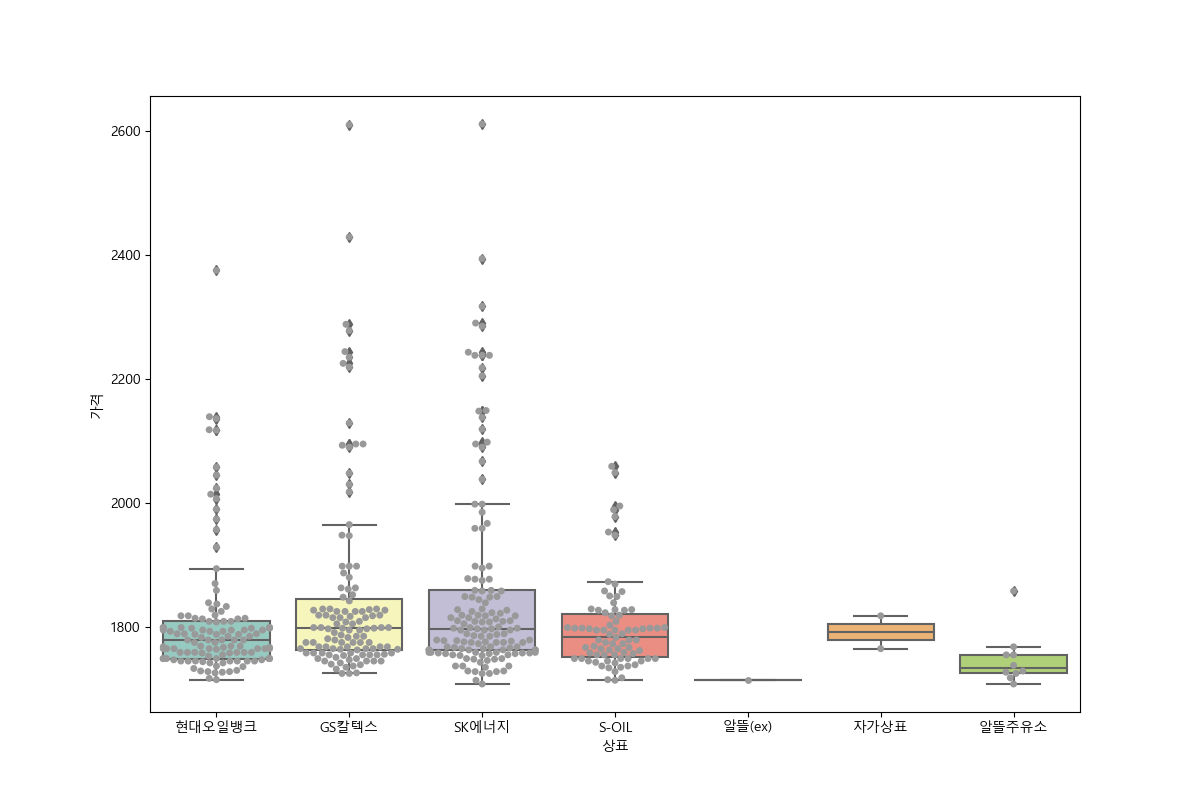

In [ ]:
plt.figure(figsize=(12,8))
sns.boxplot(x='상표', y='가격', data=stations, palette='Set3')
sns.stripplot(x='상표', y='가격', data=stations, color='.6')
Image("./Figure_3.png")

### 서울시 구별 주유소 가격 확인하기

In [ ]:
import json
import folium
import googlemaps
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
stations.sort_values(by='가격', ascending=False).head(10)

,Oil_store,주소,가격,셀프,상표,구
288,서남주유소,서울 중구 통일로 30,2611.0,N,SK에너지,중구
253,서계주유소,서울특별시 용산구 청파로 367 (청파동),2610.0,N,GS칼텍스,용산구
287,필동주유소,서울 중구 퇴계로 196 (필동2가),2429.0,N,GS칼텍스,중구
286,SK에너지(주) 퇴계로주유소,서울 중구 퇴계로 228 (필동2가),2394.0,N,SK에너지,중구
463,제이제이주유소,서울 강남구 언주로 716,2375.0,N,현대오일뱅크,강남구
102,선우상사Q엔느,서울 서초구 방배로 66 (방배동),2317.0,N,SK에너지,서초구
252,동자동주유소,서울 용산구 한강대로104길 6 (동자동),2290.0,N,SK에너지,용산구
462,(주)만정에너지,서울 강남구 봉은사로 433 (삼성동),2288.0,N,GS칼텍스,강남구
461,SK논현주유소,서울 강남구 논현로 747 (논현동),2285.0,N,SK에너지,강남구
384,구로주유소,서울 구로구 구로동로 137 (구로동),2278.0,N,GS칼텍스,구로구


In [ ]:
stations.sort_values(by='가격', ascending=True).head(10)

,Oil_store,주소,가격,셀프,상표,구
176,가로공원주유소,서울 양천구 가로공원로 165 (신월동),1708.0,N,SK에너지,양천구
303,뉴신정주유소,서울 강서구 곰달래로 207 (화곡동),1708.0,N,알뜰주유소,강서구
70,만남의광장주유소,서울 서초구 양재대로12길 73-71,1714.0,Y,알뜰(ex),서초구
178,현대주유소,서울 양천구 남부순환로 372 (신월동),1714.0,Y,S-OIL,양천구
177,(주)타이거오일 신정주유소,서울 양천구 중앙로 226 (신정동),1714.0,Y,SK에너지,양천구
413,(주)헨지스에너지 구도일주유소 도봉,서울 도봉구 도봉로 706 (방학동),1715.0,Y,S-OIL,도봉구
412,(주)자연에너지 햇살주유소,서울 도봉구 방학로 142 (방학동),1715.0,Y,현대오일뱅크,도봉구
414,도봉제일주유소(주)송만에너지,서울 도봉구 도봉로 783 (도봉동),1717.0,N,현대오일뱅크,도봉구
55,구도일주유소 두꺼비,서울 서대문구 성산로 312,1718.0,Y,S-OIL,서대문구
304,화곡역주유소,서울 강서구 강서로 154 (화곡동),1718.0,Y,알뜰주유소,강서구


In [ ]:
import numpy as np
gu_data = pd.pivot_table(stations, index=['구'], values=['가격'], aggfunc=np.mean)
gu_data.head()

,가격
구,
강남구,1962.117647
강동구,1835.928571
강북구,1756.076923
강서구,1789.406250
관악구,1813.928571


In [ ]:
geo_path = "C:\\Users\\Downloads\\skorea_municipalities_geo_simple.json"
geo_str = json.load(open(geo_path, encoding='utf-8'))

map = folium.Map(location=[37.5502, 126.982], zoom_start=10.5, 
                 tiles='Stamen Toner')

map.choropleth(geo_data = geo_str,
               data = gu_data,
               columns=[gu_data.index, '가격'],
               fill_color='PuRd', #PuRd, YlGnBu
               key_on='feature.id')
map

### 서울시 주유소 가격 상,하위 10개 지도에 표기

In [ ]:
# 가격 상위 10개 주유소를 oil_price_top10 변수에 저장
oil_price_top10 = stations.sort_values(by='가격', ascending=False).head(10)
oil_price_top10

# 가격 하위 10개 주요소를 oil_price_bottom10 변수에 저장
oil_price_bottom10 = stations.sort_values(by='가격', ascending=True).head(10)
# oil_price_bottom10
oil_price_top10

,Oil_store,주소,가격,셀프,상표,구
288,서남주유소,서울 중구 통일로 30,2611.0,N,SK에너지,중구
253,서계주유소,서울특별시 용산구 청파로 367 (청파동),2610.0,N,GS칼텍스,용산구
287,필동주유소,서울 중구 퇴계로 196 (필동2가),2429.0,N,GS칼텍스,중구
286,SK에너지(주) 퇴계로주유소,서울 중구 퇴계로 228 (필동2가),2394.0,N,SK에너지,중구
463,제이제이주유소,서울 강남구 언주로 716,2375.0,N,현대오일뱅크,강남구
102,선우상사Q엔느,서울 서초구 방배로 66 (방배동),2317.0,N,SK에너지,서초구
252,동자동주유소,서울 용산구 한강대로104길 6 (동자동),2290.0,N,SK에너지,용산구
462,(주)만정에너지,서울 강남구 봉은사로 433 (삼성동),2288.0,N,GS칼텍스,강남구
461,SK논현주유소,서울 강남구 논현로 747 (논현동),2285.0,N,SK에너지,강남구
384,구로주유소,서울 구로구 구로동로 137 (구로동),2278.0,N,GS칼텍스,구로구


In [ ]:
def location(KEYWORD) :
  import numpy as np
  import pandas as pd
  import requests
  import json
  import random
  from bs4 import BeautifulSoup
  try :
      app_key = ''
      Authorization = {
      "Authorization" : "KakaoAK "+app_key
      }
      query = {
          "query":KEYWORD
      }
      aa = requests.post('https://dapi.kakao.com/v2/local/search/address.json', headers=Authorization, data=query)
      bb = json.loads(aa.text)
      #if len(bb)==0 :
      if bb['documents'] == [] :
          print('주소를 검색할 수 없습니다')
          pass
      else :
        #   print(bb)            
          TT = bb['documents'][0]
          TT2 = {
              "SIDO":TT['address']['region_1depth_name'],
              "SGG": TT['address']['region_2depth_name'],
              "EMD": TT['address']['region_3depth_name'],
              "HEMD": TT['address']['region_3depth_h_name'],
              "BUN1": TT['address']['main_address_no'],
              "BUN2": TT['address']['sub_address_no'],
              "SAN": TT['address']['mountain_yn'],
              "EMD_CODE": TT['address']['b_code'],
              "HEMD_CODE": TT['address']['h_code'],
              "ROAD_ADDRESS": TT['road_address']['address_name'],
              #'ZIP_CODE': TT['address']['zip_code'],
              'ZONE_NO': TT['road_address']['zone_no'],
              'LON': TT['x'],
              'LAT': TT['y']
          }

      if len(TT2.keys())!=0 :
          TT2['SPNU'] = TT2['EMD_CODE'] + "-" + ("1" if TT2['SAN']=="N" else "2") + TT2['BUN1'].zfill(4) + TT2['BUN2'].zfill(4)
      return TT2
  except :
      print("주소를 확인할 수 없습니다")
      pass

In [ ]:
# 주유가격 상위 10개 주유소의 위도, 경도
from tqdm import tqdm_notebook

lat = []
lng = []

for n in tqdm_notebook(oil_price_top10.index):
    try:
        tmp_add = str(oil_price_top10['주소'][n]).split('(')[0]
        tmp_add = tmp_add.strip()
        tmp_map = location(tmp_add)

        tmp_loc = tmp_map
        lat.append(tmp_loc['LAT'])
        lng.append(tmp_loc['LON'])
        
    except:
        lat.append(np.nan)
        lng.append(np.nan)
        print("Here is nan !")
        
oil_price_top10['lat'] = lat
oil_price_top10['lng'] = lng
# oil_price_top10

lat2 = []
lng2 = []

for i in tqdm_notebook(oil_price_bottom10.index):
    try:
        tmp_add2 = str(oil_price_bottom10['주소'][i]).split('(')[0]
        tmp_add2 = tmp_add2.strip()
        tmp_map2 = location(tmp_add2)

        tmp_loc2 = tmp_map2
        lat2.append(tmp_loc2['LAT'])
        lng2.append(tmp_loc2['LON'])
        
    except:
        lat2.append(np.nan)
        lng2.append(np.nan)
        print("Here is nan !")
        
oil_price_bottom10['lat'] = lat2
oil_price_bottom10['lng'] = lng2
oil_price_bottom10

C:\Users\GONGGA~1\AppData\Local\Temp/ipykernel_27656/4292604130.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n in tqdm_notebook(oil_price_top10.index):


  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\GONGGA~1\AppData\Local\Temp/ipykernel_27656/4292604130.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(oil_price_bottom10.index):


  0%|          | 0/10 [00:00<?, ?it/s]

,Oil_store,주소,가격,셀프,상표,구,lat,lng
176,가로공원주유소,서울 양천구 가로공원로 165 (신월동),1708.0,N,SK에너지,양천구,37.5370203692233,126.834298807985
303,뉴신정주유소,서울 강서구 곰달래로 207 (화곡동),1708.0,N,알뜰주유소,강서구,37.5315624983884,126.856035365887
70,만남의광장주유소,서울 서초구 양재대로12길 73-71,1714.0,Y,알뜰(ex),서초구,37.4596446385464,127.042624862658
178,현대주유소,서울 양천구 남부순환로 372 (신월동),1714.0,Y,S-OIL,양천구,37.5339097605129,126.829178494291
177,(주)타이거오일 신정주유소,서울 양천구 중앙로 226 (신정동),1714.0,Y,SK에너지,양천구,37.5167468205193,126.854738127061
413,(주)헨지스에너지 구도일주유소 도봉,서울 도봉구 도봉로 706 (방학동),1715.0,Y,S-OIL,도봉구,37.6674517132657,127.043562669797
412,(주)자연에너지 햇살주유소,서울 도봉구 방학로 142 (방학동),1715.0,Y,현대오일뱅크,도봉구,37.6631054665765,127.036402243593
414,도봉제일주유소(주)송만에너지,서울 도봉구 도봉로 783 (도봉동),1717.0,N,현대오일뱅크,도봉구,37.6744735831616,127.044066665278
55,구도일주유소 두꺼비,서울 서대문구 성산로 312,1718.0,Y,S-OIL,서대문구,37.5660708443759,126.924941152249
304,화곡역주유소,서울 강서구 강서로 154 (화곡동),1718.0,Y,알뜰주유소,강서구,37.5407680113225,126.8414715329


In [ ]:
# 주유가격 하위 10개 주유소의 위도, 경도
map = folium.Map(location=[37.5202, 126.975], zoom_start=10.5)

for n in oil_price_top10.index:
    if pd.notnull(oil_price_top10['lat'][n]):
        folium.CircleMarker([oil_price_top10['lat'][n], oil_price_top10['lng'][n]], 
                                  radius=15, color='#CD3181', 
                                  fill_color='#CD3181',
                                  fill=True).add_to(map)
    
for n in oil_price_bottom10.index:
    if pd.notnull(oil_price_bottom10['lat'][n]): 
        folium.CircleMarker([oil_price_bottom10['lat'][n], 
                                  oil_price_bottom10['lng'][n]], 
                                  radius=15, color='#3186cc', 
                                  fill_color='#3186cc',
                                  fill=True).add_to(map)
        
map